In [1]:
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler, OneHotEncoder
import pandas as pd
import numpy as np
import json

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [3]:
features_to_drop = [
    '¿Qué medicación/es toma actualmente cuando tiene dolor de cabeza?', # Possible biased feature by the patient doctor
    '¿Qué medicación preventiva se encuentra usando?', # Possible biased feature by the patient doctor
    '¿Qué medicación preventiva usó?', # Possible biased feature by the patient doctor
    '¿Utilizó alguna vez para su dolor aplicaciones de botox?', # Possible biased feature by the patient doctor
    '¿Le dieron alguna vez medicación preventiva?', # Possible biased feature by the patient doctor
    'Señale la o las afirmaciones correctas en cuanto a las características  de su dolor luego del golpe en la cabeza', # This feature has almost no data
    'Cuán seguido bebe alcohol', # This feature has not enough data
    '¿Cómo considera que es su respuesta a la medicación preventiva actual?', # This feature has not enough data and it can algo be biased by the doctor
    'Actualmente bebo alcohol', # This is a binary feature but has almost no data
    'Actualmente fumo tabaco en cualquiera de sus formas', # This is a binary feature but has almost no data
    'Uso drogas ilícitas', # This is a binary feature but has almost no data
]

columns_to_drop = [
    'ai_condition',
    'ai_eval',
    'condition',
    'organization_id',
    'questionnarie_id',
    '¿Esta es su primer vez con el sistema de Pre-Consulta?'
]

subject_info_cols = {
    'ID consulta': 'medical_consultation_id',
    'ID paciente': 'patient_id',
    'DNI': 'patient_identifier',
    'ID médico': 'practitioner_id',
    'Fecha de consulta': 'questionnarie_date'
}

target_col = {
    'Diagnóstico del médico': 'condition'
}

numerical_demografic_features = [
    'patient_age',
    'patient_height',
    'patient_weight'
]

categorical_demografic_features = {
    'patient_gender': 'Otros'
}

numerical_features = [
    'En cuanto a la intensidad del dolor, señale en una escala de 1 a 10 la intensidad máxima a la que han llegado sus dolores',
    '¿Cuántos días en los últimos 3 meses no ha podido ir a trabajar por su cefalea?',
    '¿Cuántos días en los últimos 3 meses no ha realizado sus tareas domésticas por sus cefaleas?',
    '¿Cuántos días en los últimos 3 meses se perdió actividades familiares, sociales o lúdicas por sus cefaleas?',
    '¿Cuántos días en los últimos 3 meses se redujo por la mitad su productividad en el trabajo por sus cefaleas?',
    '¿Cuántos días en los últimos 3 meses se redujo por la mitad su productividad en la realización de tareas domésticas por la presencia de cefalea?',
]

multi_label_features = [
    'Señale si el o los síntomas que preceden su dolor de cabeza cumple alguno de las siguientes características',
    'Señale si presenta alguna de las siguientes características durante su dolor',
    'Señale si presenta alguna de las siguientes características previo a su dolor de cabeza',
    'Señale si junto con su dolor de cabeza, experimentó alguno de los siguientes síntomas',
    'He identificado los siguientes desencadenantes de mi dolor que siempre o casi siempre que me expongo, tengo dolor de cabeza',
    'Indique cuál/cuáles de las siguientes afirmaciones es correcta'
]

#key: feature col name, value: The label to drop to avoid linear correlation between new one hot encoded labels in the one vs all fashion 
single_label_features = {
    'Cuando tiene dolor de cabeza, ¿con qué frecuencia desearía poder acostarse?': 'Nunca',
    'En las últimas 4 semanas, ¿con qué frecuencia el dolor de cabeza ha limitado su capacidad para concentrarse en el trabajo o en las actividades diarias?': 'Nunca',
    'En las últimas 4 semanas, ¿con qué frecuencia se ha sentido demasiado cansada/o para trabajar o realizar las actividades diarias debido a su dolor de cabeza?': 'Nunca',
    'En las últimas 4 semanas, ¿con qué frecuencia se ha sentido harta/o o irritada/o debido a su dolor de cabeza?': 'Nunca',
    'En relación a la actividad física, marque la que corresponda': 'No hago ejercicio',
    'En relación a mis hábitos de sueño': 'Duermo bien de noche',
    'Por favor indique que parte de la cabeza o cara le duele': 'A los costados de la cabeza (bitemporal)',
    'Señale la opción correcta con respecto a la frecuencia de sus dolores (cuantas veces tiene dolor por semana o por mes, por ejemplo)': 'Tengo dolor todos los días',
    '¿Con qué frecuencia el dolor de cabeza limita su capacidad para realizar actividades diarias habituales como las tareas domésticas, el trabajo, los estudios o actividades sociales?': 'Nunca',
    '¿Cuánto tiempo le dura la cefalea o dolor de cabeza si no toma ningún remedio, o si lo toma pero no tiene respuesta?': 'Tengo un dolor continuo desde hace 3 meses o más',
    '¿Durante el episodio de dolor de cabeza, ha notado que le molestan las luces o los sonidos y que trata de evitarlos?': 'No, no me molestan ni la luz ni los sonidos',
    '¿Siente que su dolor de cabeza es pulsátil (le late la cabeza) u opresivo (siente como si le estuviesen apretando la cabeza)?': 'No, siento como agujazos o cuchilladas en alguna parte de la cabeza',
    'Cuando usted tiene dolor de cabeza, ¿con qué frecuencia el dolor es intenso?': 'Nunca'
}

# key: feature col name, value: The possitive label
binary_features = {
    '¿Este dolor es algo que comenzó recientemente (en el último mes)?': 'Sí, es un dolor que nunca tuve en mi vida y que comenzó hace menos de un mes',
    '¿Ha notado que su dolor empeora con el ejercicio, como caminar, correr o subir escaleras?': 'Si, empeora si me muevo. Trato de quedarme quieto o acostado',
    '¿Ha sentido náuseas, ganas de vomitar o ha llegado a vomitar durante o después de su dolor de cabeza?': 'Si, he tenido náuseas o ganas de vomitar y/o he llegado a vomitar'
}

# all features that are strings codifying arrays of features
array_features = numerical_features + multi_label_features + list(single_label_features.keys()) + list(binary_features.keys())

response_to_drug_cols = [
    '¿Cómo considera que es su respuesta a la medicación Diclofenac?',
    '¿Cómo considera que es su respuesta a la medicación Ibuprofeno (Ibupirac)?',
    '¿Cómo considera que es su respuesta a la medicación Ketorolac?',
    '¿Cómo considera que es su respuesta a la medicación Paracetamol?',
    '¿Cómo considera que es su respuesta a la medicación Ergotamina (migral)?',
    '¿Cómo considera que es su respuesta a la medicación Sumatriptán (migratriptan, micranil, imigran, rontadol)?',
    '¿Cómo considera que es su respuesta a la medicación Ácido Tolfenámico (Flocur)?',
    '¿Cómo considera que es su respuesta a la medicación Naratriptán  (Naramig)?',
    '¿Cómo considera que es su respuesta a la medicación Sumatriptán Naproxeno (Naprux)?',
    '¿Cómo considera que es su respuesta a la medicación Eletriptán (Relpax)?',
    '¿Cómo considera que es su respuesta a la medicación Indometacina?',
    '¿Cómo considera que es su respuesta al botox?'
]

invalid_conditions = [
    'dni mal',
    'duplicado',
    'mal dni',
    'mal el dni',
    'moigraña episodica midas mal',
    'no aparece el dni',
    'sin información sobre cefalea'
]

condition_group = {
    'migraña sin aura': 'migraña sin aura',
    'migraña cronica': 'migraña sin aura',
    'migraña episodica': 'migraña sin aura',
    'migraña hemiplejica': 'migraña sin aura',
    'migraña vestibular': 'migraña sin aura',
    'migraña vestibular/migraña sin aura': 'migraña sin aura',
    'cefalea mixta': 'migraña sin aura',
    'cefalea secundaria': 'cefalea secundaria',
    'cefalea 2ria': 'cefalea secundaria',
    'cefalea postrcranectomia': 'cefalea secundaria',
    'algia facial': 'algia facial',
    'algia craneal': 'algia facial',
    'algia facial atipica': 'algia facial',
    'neuralgia occipital': 'algia facial',
    'neuralgia del trigemino': 'algia facial',
    'disfuncion atm': 'algia facial',
    'cefalea trigemino autonomica': 'CTA',
    'cefalea trigémino-autonómica': 'CTA',
    'cefalea en racimos': 'CTA',
    'cefalea tensional': 'cefalea tensional',
    'cefalea al esfuerzo': 'cefalea tensional',
    'cefalea en puntadas': 'cefalea tensional',
    'migraña con aura': 'migraña con aura'
}

desencadenantes_col = 'He identificado los siguientes desencadenantes de mi dolor que siempre o casi siempre que me expongo, tengo dolor de cabeza'
desencadenantes_values = [
    'No tengo ningún desencadenante',
    'Muchas horas de sueño',
    'Pocas horas de sueño',
    'Saltearse comidas',
    'Calor intenso',
    'Cambios de clima o de la presión atmosférica',
    'Algunos alimentos u olores',
    'El período o menstruación',
    'Situaciones de stress',
    'Ejercicio moderado',
    'Luces brillantes o titilantes',
    'Vehículo en movimiento',
    'Viaje en avión',
    'Alcohol',
    'Ruido'
]

affirmations_col = 'Indique cuál/cuáles de las siguientes afirmaciones es correcta'
affirmations_values = [
    'Tengo diagnóstico previo de cáncer con o sin tratamiento',
    'Tengo diagnóstico previo de alguna de las siguientes condiciones: HIV, meningitis, toxoplasmosis, linfoma, malfomación vascular/cerebral',
    'Estoy recibiendo tratamiento inmunosupresor por cualquier causa',
    'Tengo más de 50 años y hasta ahora nunca había tenido este dolor de cabeza',
    'Tengo fiebre sin una causa aparente clara (diagnóstico de gripe o resfrío, neumonía u otra infección diagnosticada por un médico)',
    'He perdido más de 5 kilos en el último mes sin hacer dieta o incrementado actividad física',
    'La cefalea o dolor de cabeza apareció de golpe y llegó a su máxima intensidad en tan solo segundos',
    'Tuve un golpe muy fuerte en la cabeza y este dolor apareció luego o hasta 7 días después del golpe',
    'La cefalea solo me ocurre durante o luego de toser o hacer un esfuerzo físico',
    'El dolor de cabeza empeora luego de 15 minutos parado o sentado y suele mejorar si me acuesto por más de 15 minutos',
    'El dolor de cabeza me aparece o apareció durante la actividad sexual',
    'Me realizaron recientemente una punción lumbar'
]

In [4]:
def parse_desencadenantes_value(values):
    return [
        'otro'
        if value not in desencadenantes_values else value
        for value in values
    ]

def clean_affirmation_values(values):
    return [
        value for value in values
        if value in affirmations_values
    ]

# parse array values
def parse_array_value(x):
    return [
        item
        for item in json.loads(x.replace('"','').replace("'",'"'))
    ]

# parse numerical valua
def parse_numerical_value(x):
    if len(x) != 1:
        raise ValueError('numerical value should be unique')

    return int(float(x[0]))
    

def clean_condition_value(x):
    return x.replace('\n', ' ').lower().strip()


def calculate_response_to_drugs(x):
    x_str = ' '.join(x)
    for option, value in [('Excelente',1), ('Buena', 0.75), ('Regular', 0.5), ('Mala', 0.25)]:
        if option in x_str:
            return option
    return 0


def check_and_extract_single_value(x):
    if len(x) != 1:
        raise ValueError(f'{x} should be an array of length 1.')
    return x[0];

def fill_empty_array_rows(x):
    return "['empty']" if x == '' else x

In [5]:
curated_targets_file = '../data/predoc_fleni_targets_curada.xlsx'
df_predoc_responses_file = '../data/predoc_fleni_responses.csv'
target_schema = 'Migrañas vs otras'

# Read and clean-up curated target data

In [6]:
curated_targets_cols = {
    **subject_info_cols,
    **target_col
}

df_curated_targets = pd.read_excel(curated_targets_file)[curated_targets_cols.keys()]

df_curated_targets.rename(
    curated_targets_cols,
    inplace=True,
    axis=1
)

df_curated_targets.dropna(
    subset=['condition'],
    inplace=True,
    axis=0
)

df_curated_targets.loc[:, 'condition'] = df_curated_targets['condition'].apply(
    clean_condition_value
)

valid_conditions = ~df_curated_targets['condition'].isin(
    invalid_conditions
)
df_curated_targets = df_curated_targets[valid_conditions]
df_curated_targets['condition'] = df_curated_targets['condition'].apply(
    lambda x: condition_group[x]
)

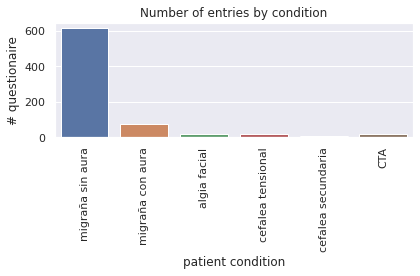

In [7]:
ax = sns.countplot(x=df_curated_targets['condition'])
plt.xlabel('patient condition')
plt.ylabel('# questionaire')
plt.title('Number of entries by condition')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Read and clean-up feature dataset

In [8]:
df_predoc_responses = pd.read_csv(
    df_predoc_responses_file,
    sep=';',
    keep_default_na=False
)

df_predoc_responses.rename(
    lambda x: x.strip(),
    inplace=True,
    axis=1
)

df_predoc_responses.drop(
    columns_to_drop + features_to_drop,
    inplace=True,
    axis=1
)

# Remove subject with incorrect data in some cols
df_predoc_responses = df_predoc_responses[df_predoc_responses.patient_identifier != 17560351]

## Calculate response to drug

In [9]:
# Calculate the response to drugs without discriminate between drugs (we take the better response to drugs)
df_predoc_responses['respuesta a medicamento'] = df_predoc_responses.loc[:,response_to_drug_cols].apply(
    calculate_response_to_drugs,
    axis=1
)
df_predoc_responses.drop(
    response_to_drug_cols,
    inplace=True,
    axis=1
)

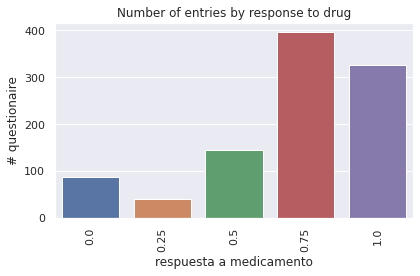

In [10]:
ax = sns.countplot(x=df_predoc_responses['respuesta a medicamento'])
plt.xlabel('respuesta a medicamento')
plt.ylabel('# questionaire')
plt.title('Number of entries by response to drug')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Parse columns from string to array

In [11]:
# Extract value of excluyent values features (binary features are excluyents)
single_value_cols = list(binary_features.keys()) + list(single_label_features.keys())

# Remove rows with empty binary data
completed_binary_row = df_predoc_responses[single_value_cols].apply(
    lambda xs: '' not in xs.values,
    axis=1
)

df_predoc_responses = df_predoc_responses[completed_binary_row]

In [12]:
# Parse columns with string representations of arrays to python arrays
df_predoc_responses.loc[:,array_features] = df_predoc_responses[array_features].replace('', '[]')
df_predoc_responses.loc[:,array_features] = df_predoc_responses[array_features].apply(
    lambda col: col.apply(parse_array_value),
    axis=1
)

## Parse and scale numerical features

In [13]:
# Parse and scale numerical features between 0 and 1
df_predoc_responses.loc[:, numerical_features] = df_predoc_responses[numerical_features].apply(
    lambda col: col.apply(parse_numerical_value),
    axis=1
)

scaler = MinMaxScaler()
all_numerical_features = np.concatenate([
    numerical_features,
    numerical_demografic_features
])
df_predoc_responses.loc[:, all_numerical_features] = scaler.fit_transform(
    df_predoc_responses[all_numerical_features].values
)

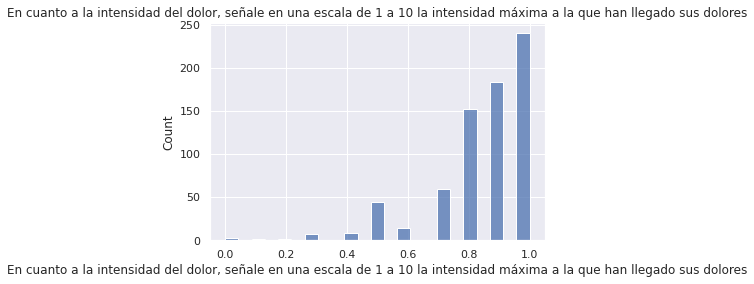

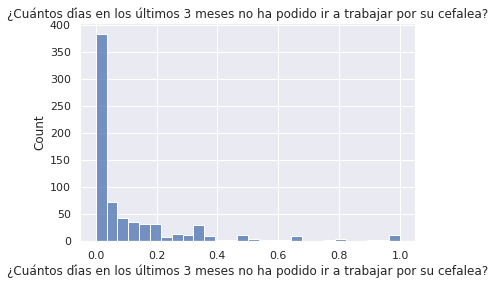

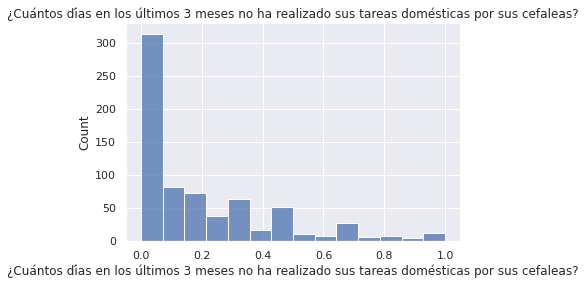

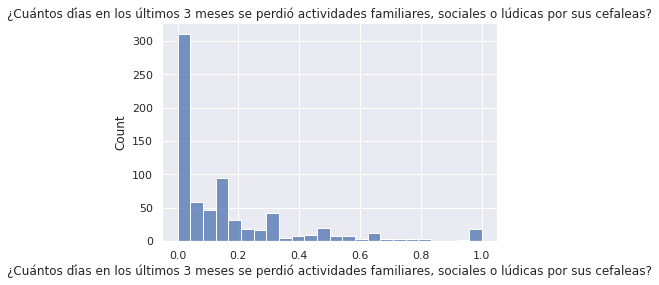

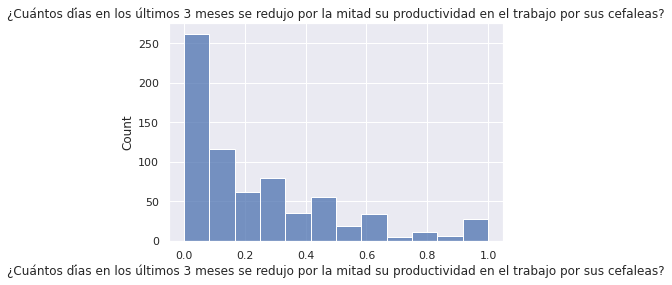

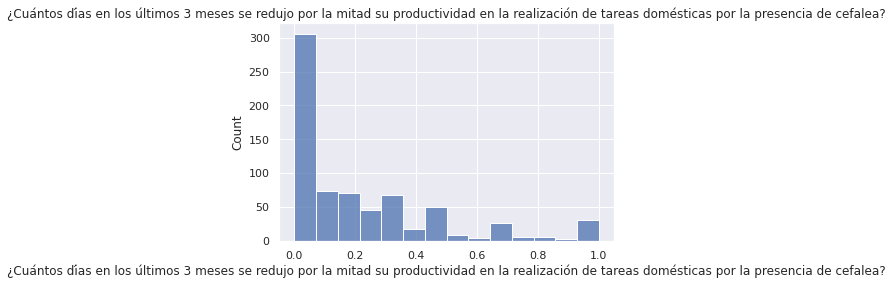

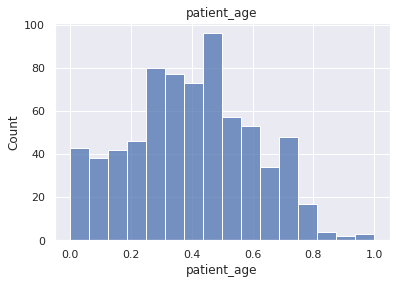

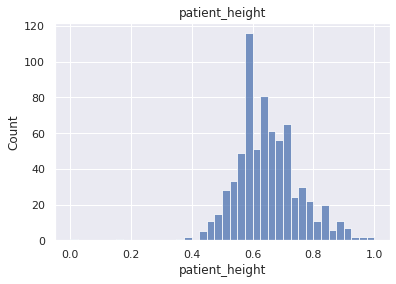

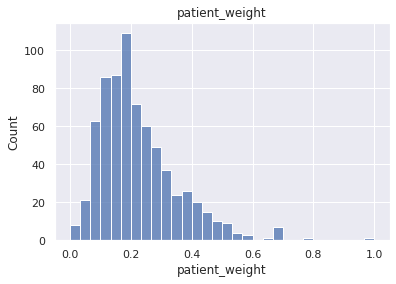

In [14]:
for feature in all_numerical_features:
    sns.histplot(x=df_predoc_responses[feature])
    plt.title(feature)
    plt.show()

In [15]:
# Extract single value from array
for col in single_value_cols:
    df_predoc_responses.loc[:, col] = df_predoc_responses[col].apply(check_and_extract_single_value)

In [16]:
# Convert binary col to 0 = False, 1 = True values
for col, pos_label in binary_features.items():
    df_predoc_responses.loc[:, col] = (df_predoc_responses[col] == pos_label).astype(int)

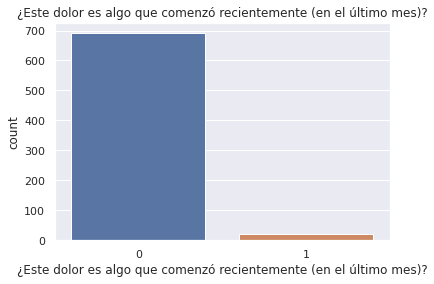

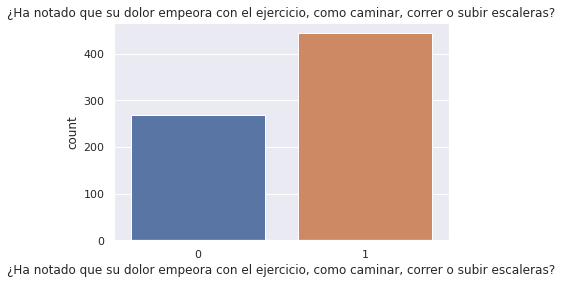

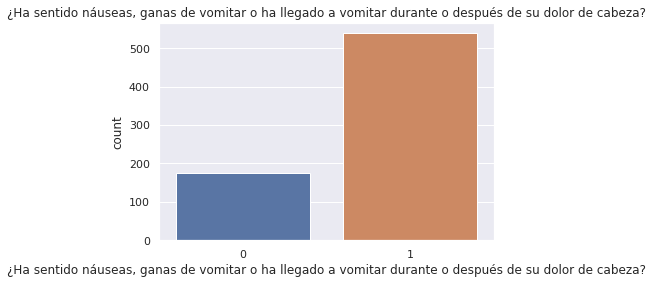

In [17]:
for col in binary_features.keys():
    sns.countplot(x=df_predoc_responses[col])
    plt.title(col)
    plt.show()

## One hot encode for single value features

In [18]:
all_single_label_features = {
    **single_label_features,
    **categorical_demografic_features
}
single_features, drop = map(list,zip(*all_single_label_features.items()))
df_temp = df_predoc_responses[single_features]

In [19]:
# One hot encode single label features droping one value per feature to break linear correlation:
all_single_label_features = {
    **single_label_features,
    **categorical_demografic_features
}
single_features, drop = map(list,zip(*all_single_label_features.items()))
encoder = OneHotEncoder(drop=drop)
X = encoder.fit_transform(df_predoc_responses[single_features])

new_single_label_features = [
    f'{feature}__{option}' 
    for options, feature, drop_option in zip(encoder.categories_, single_features, drop)
    for option in options if option != drop_option
]

df_predoc_responses[new_single_label_features] = X.toarray()
df_predoc_responses.drop(
    single_features,
    axis=1,
    inplace=True
)

In [20]:
rows = []
for options, feature, drop_option in zip(encoder.categories_, single_features, drop):
    for option in options:
        if option == drop_option:
            rows.append(['DROPPED', option, feature])
        else:
            equals = all( (df_temp[feature] == option).astype(int) == df_predoc_responses[feature + '__' + option] )
            rows.append(['CONCUERDAN' if equals else 'ERROR', option, feature])

df_temp = pd.DataFrame(rows, columns=['State','feature', 'option'])
pd.set_option('display.max_rows', len(df_temp))
display(df_temp)


,State,feature,option
0,CONCUERDAN,A veces,"Cuando tiene dolor de cabeza, ¿con qué frecue..."
1,CONCUERDAN,Muy a menudo,"Cuando tiene dolor de cabeza, ¿con qué frecue..."
2,DROPPED,Nunca,"Cuando tiene dolor de cabeza, ¿con qué frecue..."
3,CONCUERDAN,Pocas veces,"Cuando tiene dolor de cabeza, ¿con qué frecue..."
4,CONCUERDAN,Siempre,"Cuando tiene dolor de cabeza, ¿con qué frecue..."
5,CONCUERDAN,A veces,"En las últimas 4 semanas, ¿con qué frecuenci..."
6,CONCUERDAN,Muy a menudo,"En las últimas 4 semanas, ¿con qué frecuenci..."
7,DROPPED,Nunca,"En las últimas 4 semanas, ¿con qué frecuenci..."
8,CONCUERDAN,Pocas veces,"En las últimas 4 semanas, ¿con qué frecuenci..."
9,CONCUERDAN,Siempre,"En las últimas 4 semanas, ¿con qué frecuenci..."


In [21]:
df_temp = df_predoc_responses[[desencadenantes_col, affirmations_col]]

In [22]:
# Clean feature with other option
df_predoc_responses.loc[:, desencadenantes_col] = df_predoc_responses[desencadenantes_col].apply(parse_desencadenantes_value)

# Clean feature with some incorrect values we are not sure where they come from
df_predoc_responses.loc[:, affirmations_col] = df_predoc_responses[affirmations_col].apply(clean_affirmation_values)

In [23]:
for option in set(np.concatenate(df_temp[desencadenantes_col].values)):
    print(option)

print('\n----------------------\n')

for option in set(np.concatenate(df_predoc_responses[desencadenantes_col].values)):
    print(option)

Posiciones que en las me quedo dormida
Deshidratación
Contracturas
Ejercicio fuerte
Cuando como chocolate. Cuando tengo preocupaciones que me generan ansiedad
Falta de descanso. Contractura muscular.
Presión de gorra sobre mis implantes cocleares.
Dormir sin placa de turismo
Me aparece cuando duermo
Sin previo aviso
Tos
Cuando estoy mucho tiempo de un lado para el otro bajo el sol.
Ruido
Muchas horas de sueño
Dormir la sies
Contractura cervical y bruxismo
Levantar mucho peso
Contractura, tension corporal
Lectura
situaciones de exigencia o presion laboral-academica
Ejercicio físico con peso, o muy rápido que cargue la zona cervical, mirar la tv acostada, bruxiar a la noche, llorar
Si leo en vehiculo en movimiento.  Siento no solo dolor de cabeza sino tambien que me falta el aire
Actividad sexual
Luces brillantes o titilantes
Ejercicio moderado
Al sentarme a hacer alguna actividad sobre todo el estudio o dibujar. Pero luego que comienza ninacostada se le pass
Postural
Cambios de clima o 

In [24]:
for option in set(np.concatenate(df_temp[affirmations_col].values)):
    print(option)

print('\n----------------------\n')

for option in set(np.concatenate(df_predoc_responses[affirmations_col].values)):
    print(option)

Junto con mi dolor de cabeza, presento o presenté confusión, debilidad o falta de sensibilidad en alguna parte del cuerpo, visión doble, alteraciones en la vista como oscurecimientos o manchas, alteración del lenguaje, o dificultad para caminar.
Tomo ibuprofeno, paracetamol, ketorolac, flocur, diclofenac, más de 15 días por mes
Tengo más de 50 años y hasta ahora nunca había tenido este dolor de cabeza
El dolor de cabeza me aparece o apareció durante la actividad sexual
Tengo diagnóstico previo de cáncer con o sin tratamiento
Penicilinas
He perdido más de 5 kilos en el último mes sin hacer dieta o incrementado actividad física
El dolor me apareció en contexto de lesión por herpes en la cara
Tengo diagnóstico de colesterol elevado o dislipemia
El dolor de cabeza me aparece o apareció durante el orgasmo
19.00
Tengo diagnóstico de diabetes
Claritromicina
Tengo diagnóstico previo de alguna de las siguientes condiciones: HIV, meningitis, toxoplasmosis, linfoma, malfomación vascular/cerebral


# Multi label binarizer for multi label features

In [25]:
df_temp = df_predoc_responses[multi_label_features]

In [26]:
# Multi label binarizer for multi label features
new_multi_label_features = []
for feature in multi_label_features:
    mlb = MultiLabelBinarizer()
    X = mlb.fit_transform(df_predoc_responses[feature].values)
    new_multi_label_features.append([f'{feature}__{option}' for option in mlb.classes_])
    df_predoc_responses[new_multi_label_features[-1]] = X
    df_predoc_responses.drop(feature, axis=1, inplace=True)
new_multi_label_features = np.concatenate(new_multi_label_features)

In [27]:
rows = []
for feature in multi_label_features:
    for option in set(np.concatenate(df_temp[feature].values)):
        prev_values = [1 if option in row else 0 for row in df_temp[feature].values]
        equals = all( prev_values == df_predoc_responses[feature + '__' + option] )
        rows.append(['CONCUERDAN' if equals else 'ERROR', option, feature])

df_temp = pd.DataFrame(rows, columns=['State','feature', 'option'])
pd.set_option('display.max_rows', len(df_temp))
display(df_temp)

,State,feature,option
0,CONCUERDAN,Los síntomas me ocurren de un solo lado de la ...,Señale si el o los síntomas que preceden su do...
1,CONCUERDAN,"Si tengo más de un síntoma (por ejemplo, prime...",Señale si el o los síntomas que preceden su do...
2,CONCUERDAN,Cada uno de estos síntomas dura entre 5 y 60 m...,Señale si el o los síntomas que preceden su do...
3,CONCUERDAN,Todavía presente alguno de estos síntomas o me...,Señale si el o los síntomas que preceden su do...
4,CONCUERDAN,Pupila de menor tamaño o caída del párpado del...,Señale si presenta alguna de las siguientes ca...
5,CONCUERDAN,Párpados hinchados del mismo lado del dolor,Señale si presenta alguna de las siguientes ca...
6,CONCUERDAN,"Hay cosas que desencadenan mi dolor (viento, l...",Señale si presenta alguna de las siguientes ca...
7,CONCUERDAN,Nariz congestionada o secreciones de la narina...,Señale si presenta alguna de las siguientes ca...
8,CONCUERDAN,Ojo rojo o lagrimeo del mismo lado del dolor,Señale si presenta alguna de las siguientes ca...
9,CONCUERDAN,Sensación de agitación o inquietud,Señale si presenta alguna de las siguientes ca...


# Final merge between target and feature datasets

In [28]:
df_predoc_responses['questionnarie_date'] = pd.to_datetime(df_predoc_responses['questionnarie_date']).dt.date.astype('datetime64[ns]')

# Mergeo el dataframe con el target con el dataframe con los features
df = pd.merge(
    df_curated_targets,
    df_predoc_responses,
    on=list(subject_info_cols.values()),
    how='inner',
    validate='1:1'
)

# Me quedo con la primer visita de cada paciente para evitar diagnosticos sesgados
df.sort_values(
    by='questionnarie_date',
    ascending=True,
    ignore_index=True,
    inplace=True
)
df.drop_duplicates(
    subset='patient_identifier',
    keep='first',
    ignore_index=True,
    inplace=True
)

# Elimino las columnas que son info del paciente
df.drop(
    list(subject_info_cols.values()),
    axis=1,
    inplace=True
)

In [29]:
# final feature cols
feature_cols = np.concatenate([
    ['respuesta a medicamento'],
    all_numerical_features,
    list(binary_features.keys()),
    new_single_label_features,
    new_multi_label_features
])